In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [2]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


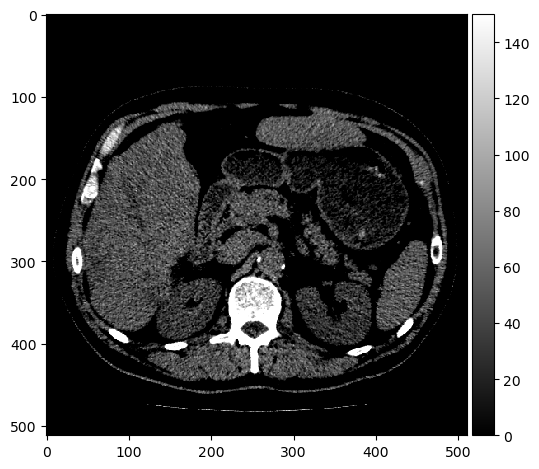

In [3]:
# Exercise 1: adjust image contrast
io.imshow(img, vmin=0, vmax=150, cmap='gray')
io.show()

In [4]:
# Exercise 2: use the annotated images (boolean masks)
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)
print(spleen_values.shape)
print(mu_spleen)
print(std_spleen)

(2230,)
49.48026905829597
14.9970794143059


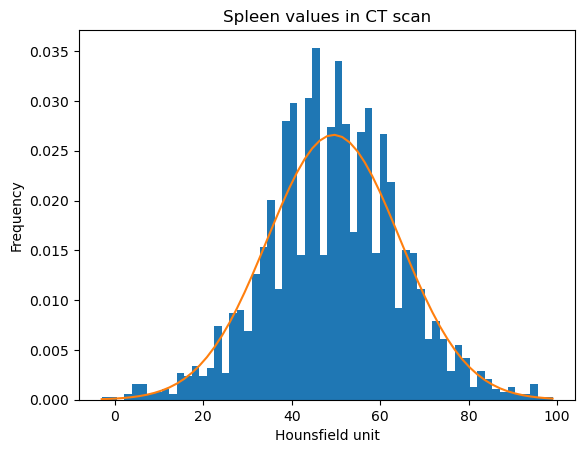

In [5]:
# Exercise 3
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

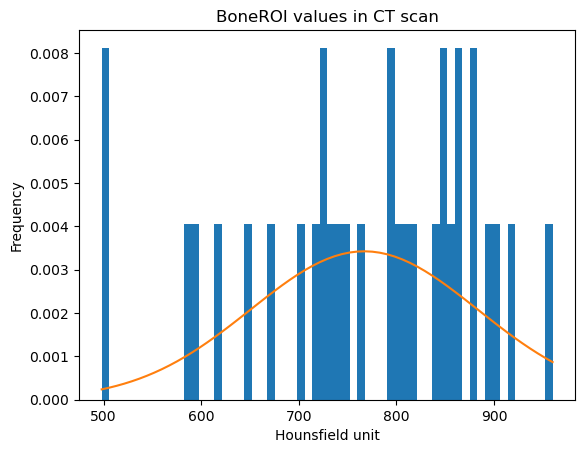

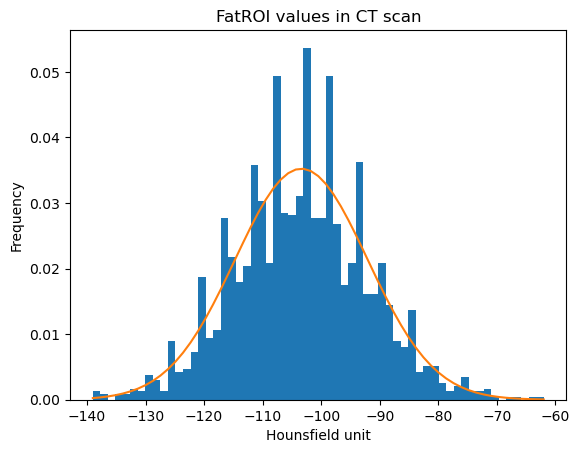

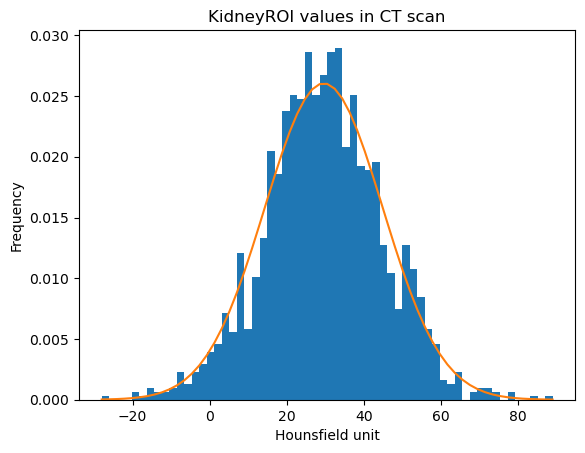

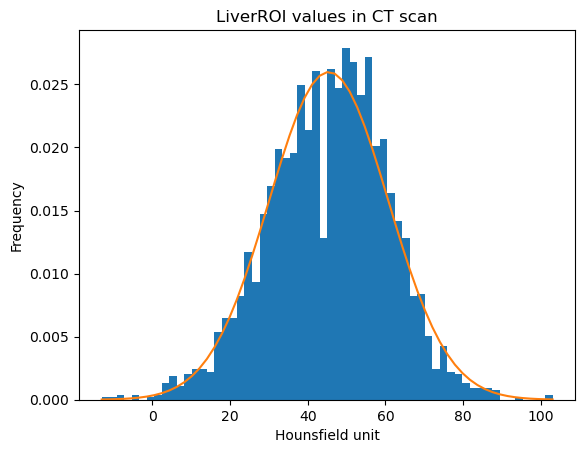

In [6]:
# Exercise 4: plot for other organsO
ROI = ['BoneROI', 'FatROI', 'KidneyROI', 'LiverROI']
mu_organs = []
std_organs = []
for roi in ROI:
    roi_img = io.imread(in_dir + roi + '.png')
    organ_mask = roi_img > 0
    organ_values = img[organ_mask]
    mu_organ = np.mean(organ_values)
    std_organ = np.std(organ_values)
    mu_organs.append(mu_organ)
    std_organs.append(std_organ)
    n, bins, patches = plt.hist(organ_values, 60, density=1)
    pdf_spleen = norm.pdf(bins, mu_organ, std_organ)
    plt.plot(bins, pdf_spleen)
    plt.xlabel('Hounsfield unit')
    plt.ylabel('Frequency')
    plt.title(roi + ' values in CT scan')
    plt.show()
    

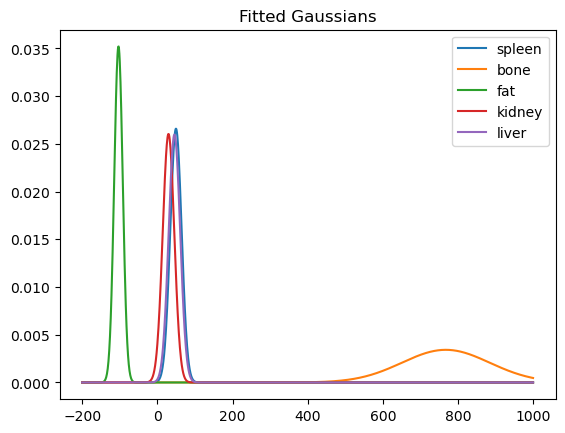

In [7]:
# Exercise 5 : fitted gaussians of the 5 organs
# Hounsfield unit limits of the plot
# ROI = ['BoneROI', 'FatROI', 'KidneyROI', 'LiverROI']
min_hu = -200
max_hu = 1000
mu_bone = mu_organs[0]
std_bone = std_organs[0]
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_organs[0], std_organs[0])
pdf_fat = norm.pdf(hu_range, mu_organs[1], std_organs[1])
pdf_kidney = norm.pdf(hu_range, mu_organs[2], std_organs[2])
pdf_liver = norm.pdf(hu_range, mu_organs[3], std_organs[3])
plt.plot(hu_range, pdf_spleen, label="spleen")
plt.plot(hu_range, pdf_bone, label="bone")
plt.plot(hu_range, pdf_fat,  label="fat")
plt.plot(hu_range, pdf_kidney, label="kidney")
plt.plot(hu_range, pdf_liver, label="liver")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

# liver, spleen, and kidney are very hard to separate.
# Thus, these 3 organs can be combined into one class 'soft tissues'

## Minimum distance classifier

In [8]:
# Exercise 7: compute class ranges defining fat, soft tissue, bone

soft_tissues = ['SpleenROI', 'KidneyROI', 'LiverROI']
soft_mask = np.zeros(img.shape, dtype = bool)

for organ in soft_tissues:
    roi_img = io.imread(in_dir + organ + '.png')
    organ_mask = roi_img > 0
    soft_mask = organ_mask | soft_mask

soft_values = img[soft_mask]
mu_soft = np.mean(soft_values)
std_soft = np.std(soft_values)

# take threshold as midpoint between 2 class value averages
t_background = -200
t_fat_soft = (mu_soft + mu_organs[1])/ 2
t_soft_bone = (mu_soft + mu_organs[0])/ 2

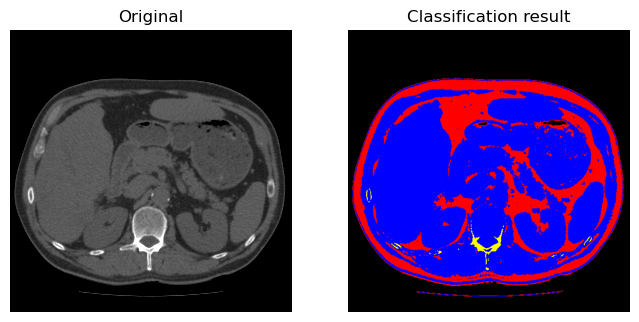

In [9]:
# Exercise 8: create class images
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone

label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

## Parametric classifier

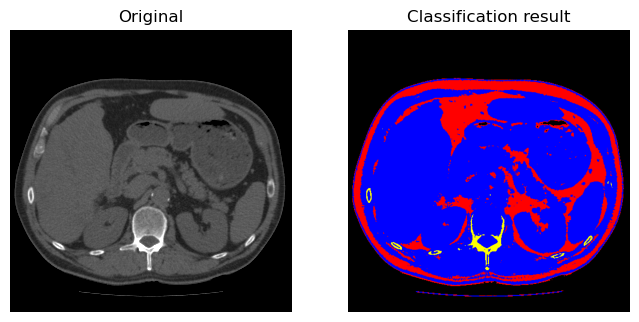

In [10]:
# Exercise 9: manually inspect class ranges
t_background = -200
t_fat_soft = -50
t_soft_bone = 300

# Exercise 10: visualise classification result
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone

label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

For value 141 the class is bone
For value -44 the class is soft tissue


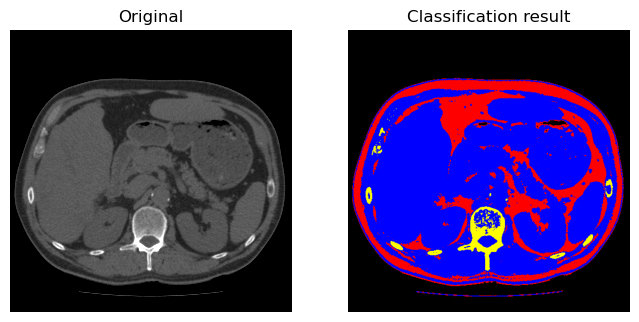

In [11]:
# Exercise 11: use norm.pdf to find optimal class ranges

# find the point when the pdf for bone > pdf soft tissue
for test_value in range(100,500):
    if norm.pdf(test_value, mu_soft, std_soft) < norm.pdf(test_value, mu_bone, std_bone):
        print(f"For value {test_value} the class is bone")
        break
        
# find the point when the pdf for soft tissue > pdf fat
for test_value in range(-100,0):
    if norm.pdf(test_value, mu_organs[1], std_organs[1]) < norm.pdf(test_value, mu_soft, std_soft):
        print(f"For value {test_value} the class is soft tissue")
        break

# visualise classification result
t_background = -200
t_fat_soft = -44
t_soft_bone = 141

fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone

label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

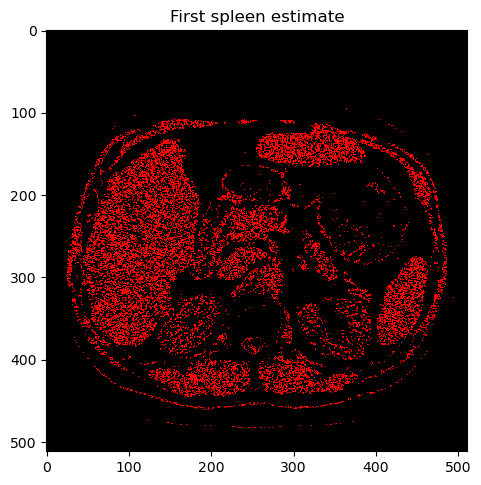

In [12]:
# Exercise 11:
t_1 = 40   # from exercise 3
t_2 = 60   # from exercise 3
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

None


C:\Users\yufan\anaconda3\envs\course02502\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


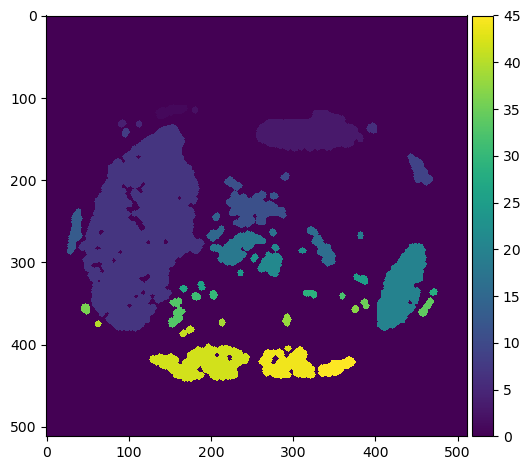

In [13]:
# Exercise 12: use morph operations to separate spleen 
# from other organs and close holes
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(4)
opened = binary_opening(closed, footprint)

label_img = measure.label(opened)
region_props = measure.regionprops(label_img)
areas = []
for region in region_props:
    areas.append(region.area)
print(areas.sort())

io.imshow(label_img)
io.show()

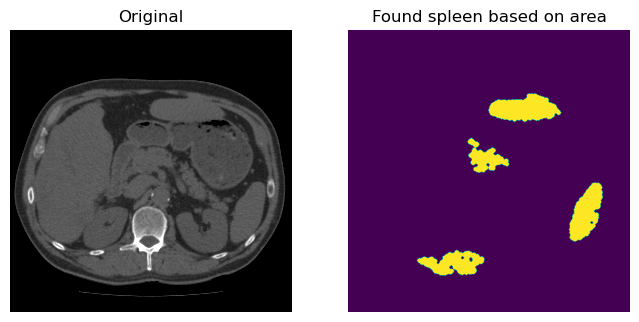

In [22]:
# Exercise 13: validate success of separated spleen

# min_area = 190
# max_area = 5000

min_area = 2000
max_area = 10000 

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

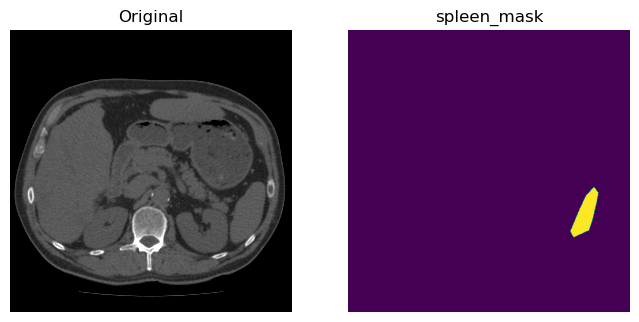

In [15]:
# expected correct answer
show_comparison(img, spleen_mask, 'spleen_mask')

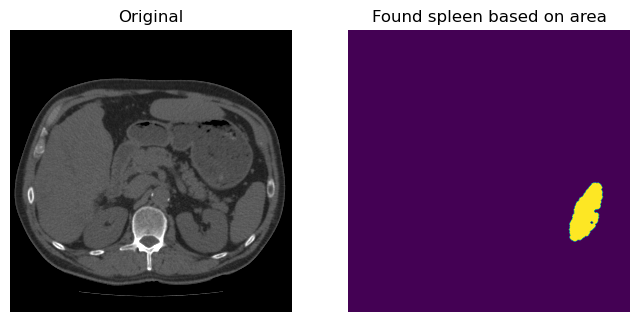

In [21]:
# Exercise 14: Extend method to several BLOB features
min_area = 2000
max_area = 10000 
min_ecc = 0.90
max_perimeter = 350 

# Create a copy of the label_img
label_img_filter = label_img.copy()
region_props = measure.regionprops(label_img)
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or region.perimeter > max_perimeter:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

In [17]:
# Exercise 15: create fx that takes in CT img and returns bin img
def spleen_finder(ct_image, max_area = 10000, min_area = 1000, min_ecc = 0.9, max_perimeter = 350, min_perimeter = 250): 
    # thresholding 
    t_1, t_2 = 20, 80
    spleen_estimate = (ct_image > t_1) & (ct_image < t_2)
    
    #  morphological operations 
    fp1, fp2 = disk(2), disk(4)
    closed = binary_closing(spleen_estimate, fp1)
    opened = binary_opening(closed, fp2)

    # image to label
    label_img = measure.label(opened)
    label_img_filter = label_img.copy()

    region_props = measure.regionprops(label_img)
    for region in region_props:
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or region.perimeter > max_perimeter or region.perimeter < min_perimeter:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    return label_img_filter > 0

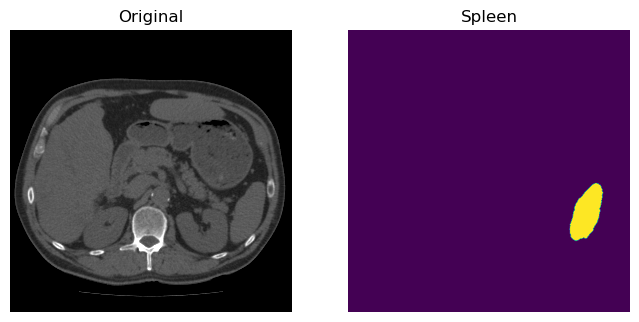

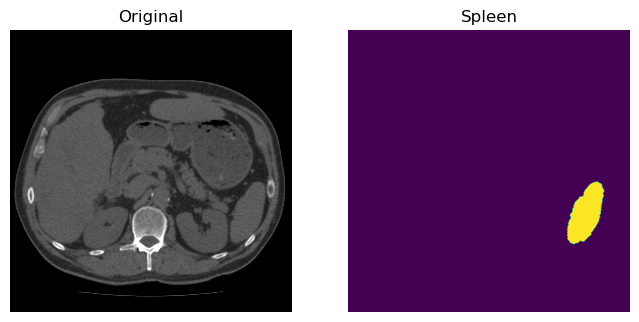

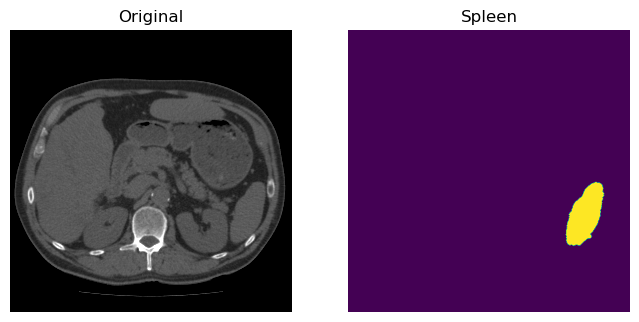

In [18]:
# Exercise 16: test fx on validation imgs
val1, val2, val3 = io.imread("data/Validation1.dcm"), io.imread("data/Validation2.dcm"), io.imread("data/Validation3.dcm")
show_comparison(img, spleen_finder(val1), 'Spleen')
show_comparison(img, spleen_finder(val2), 'Spleen')
show_comparison(img, spleen_finder(val3), 'Spleen')


In [19]:
# Exercise 17: DICE score
# Get predictions 
pred1 = spleen_finder(val1)
pred2 = spleen_finder(val2)
pred3 = spleen_finder(val3)

# get ground thruths 
gt_1 = (io.imread(in_dir + 'Validation1_spleen.png') > 0)
gt_2 = (io.imread(in_dir + 'Validation2_spleen.png') > 0)
gt_3 = (io.imread(in_dir + 'Validation3_spleen.png') > 0)

# get dice scores 
score1 = 1 - distance.dice(pred1.ravel(), gt_1.ravel())
score2 = 1 - distance.dice(pred2.ravel(), gt_3.ravel())
score3 = 1 - distance.dice(pred3.ravel(), gt_3.ravel())

print(f"Score 1 = {score1}, Score 2 = {score2}, Score 3 = {score3}")

Score 1 = 0.9558359621451105, Score 2 = 0.9471671530643051, Score 3 = 0.9715459078908771


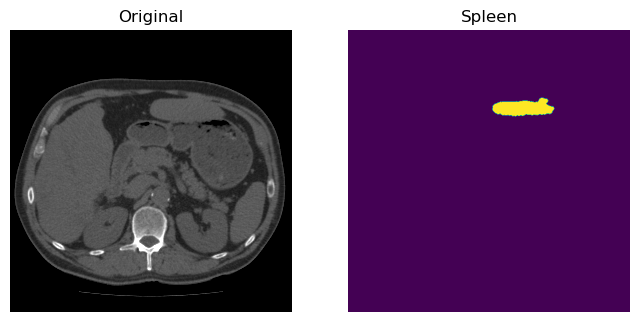

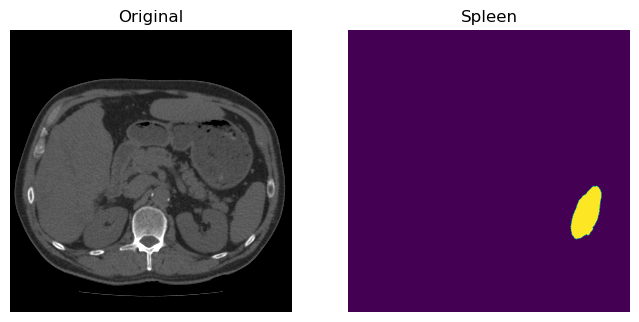

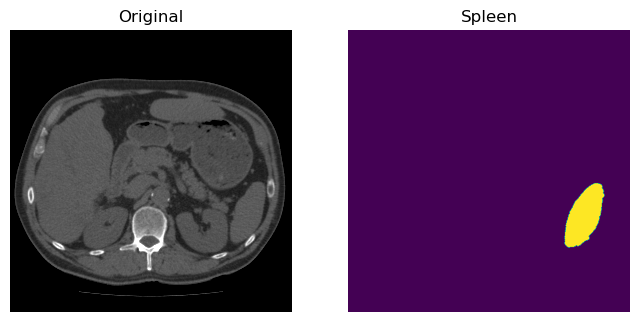

In [20]:
# Exercise 18 
test1, test2, test3 = io.imread("data/Test1.dcm"), io.imread("data/Test2.dcm"), io.imread("data/Test3.dcm")
show_comparison(img, spleen_finder(test1), 'Spleen')
show_comparison(img, spleen_finder(test2), 'Spleen')
show_comparison(img, spleen_finder(test3), 'Spleen')